In [1]:
# LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score, multilabel_confusion_matrix, roc_curve
from scipy.sparse import issparse
from skmultilearn.problem_transform import BinaryRelevance
import time

In [2]:
# DATA
df_brfss = pd.read_csv('/Users/macbook/Library/CloudStorage/GoogleDrive-nurrachmandzakiyullah@gmail.com/My Drive/23. Colab Notebooks/1. AI_Project/2. PhD_Dzaki_BRFSS/Fix_Model_HP/3. Fix Model/Final_dataset_Diabetes_Complication.csv')
x = df_brfss.iloc[:, :26].values
X = preprocessing.normalize(x)
y = df_brfss.iloc[:, 26:].values-1

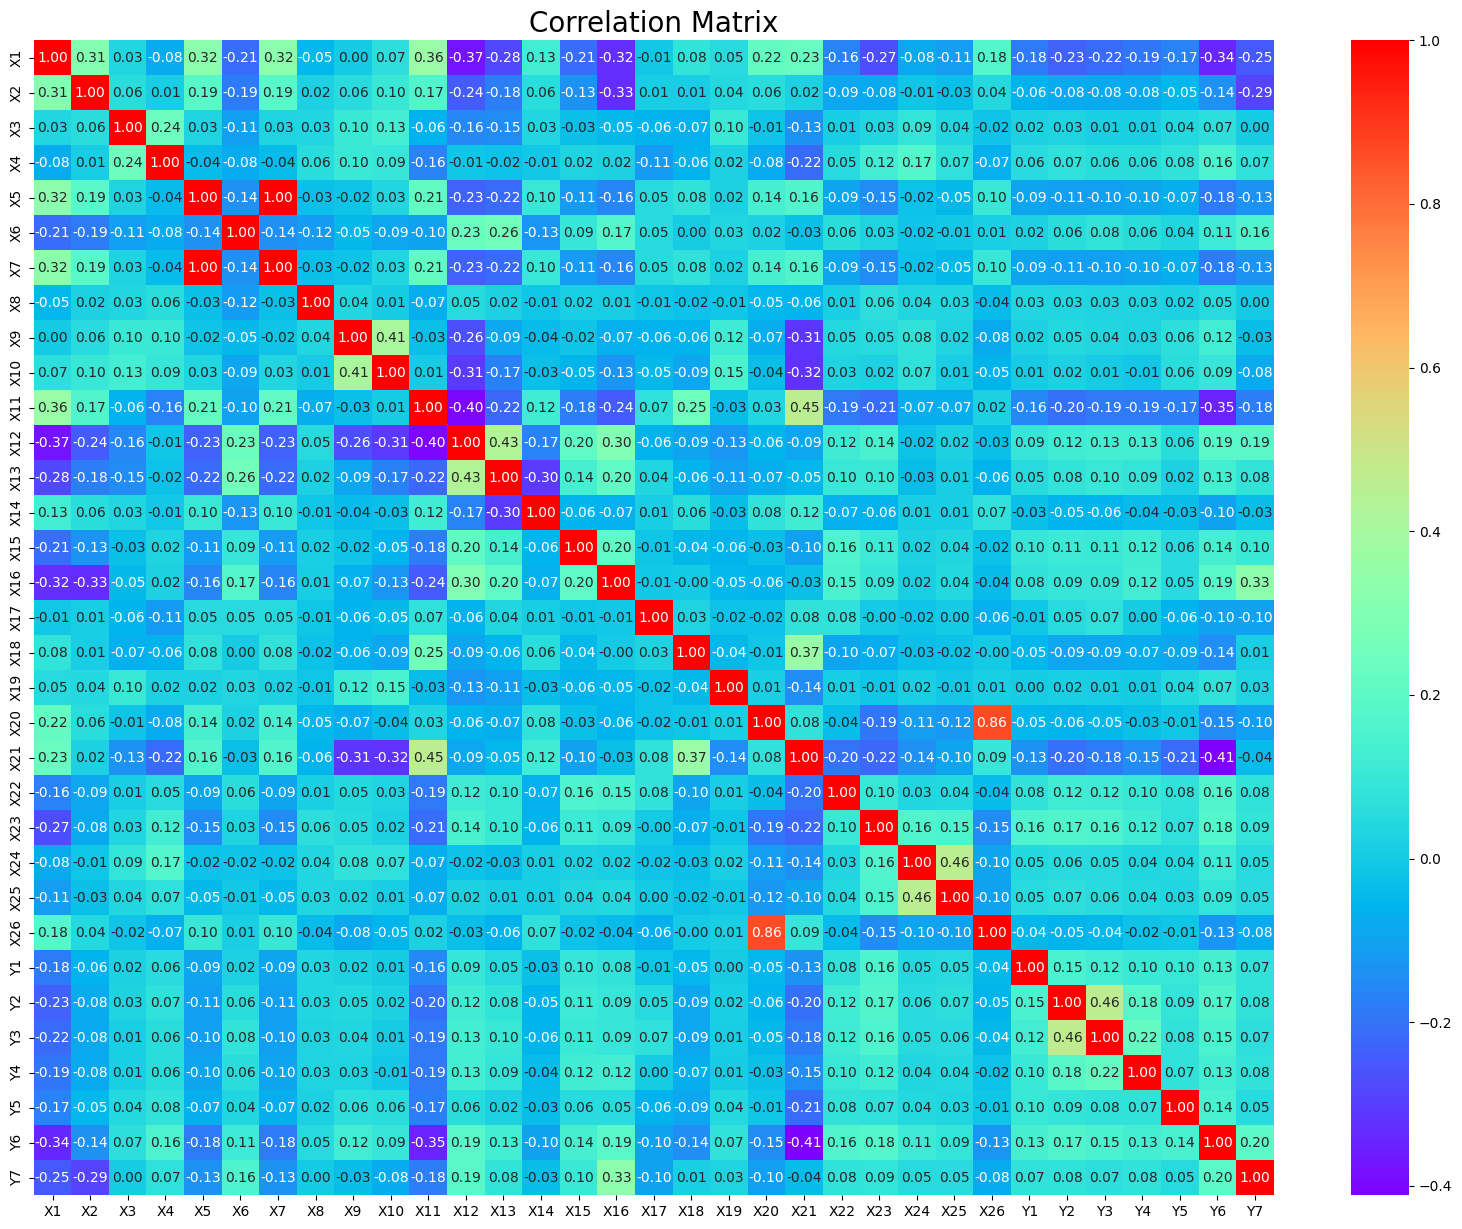

In [3]:
# Correlation matrix graph of the data set
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_brfss.corr(), annot=True, fmt=".2f", ax=ax, cmap = "rainbow" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [4]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()

In [ ]:
class CalibratedLabelRanking:
    """Calibratedn Label Ranking
    Reference Paper:
        Min-Ling Zhang and Zhi-Hua Zhou. A Review on Multi-Label Learning Algorithms
        Johannes Fürnkranz. Multilabel classification via calibrated label ranking
    """
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y):
        self.virtualLabel = y.shape[1]
        self.label_count = y.shape[1]
        self.m = X.shape[0]
        self.X = X
        self.y = y
        self.realLabelClassifiers = []
        self.virtualLabelClassifiers = []
        self.trainRealLabelClassifiers()
        self.trainVirtualLabelClassifiers()
        return self

    def trainRealLabelClassifiers(self):
        for i in range(self.label_count):
            for j in range(i+1, self.label_count):
                X_subset = []
                y_subset = []
                classifier = copy.deepcopy(self.classifier)
                for k in range(self.m):
                    if self.y[k, i] == self.y[k, j]:
                        continue
                    elif self.y[k, i] == 1:
                        X_subset.append(self.X[k, :])
                        y_subset.append(i)
                    else:
                        X_subset.append(self.X[k, :])
                        y_subset.append(j)
                try:
                    classifier.fit(np.vstack(X_subset), np.array(y_subset))
                except ValueError:
                    if y_subset[0] == i:
                        classifier = i
                    else:
                        classifier = j
                self.realLabelClassifiers.append(classifier)

    def trainVirtualLabelClassifiers(self):
        for i in range(self.label_count):
            classifier = copy.deepcopy(self.classifier)
            y_temp= self.y[:, i]
            y_subset = []
            for j in range(self.m):
                y_subset.append(i if y_temp[j] == 1 else self.virtualLabel)
            classifier.fit(self.X, y_subset)
            self.virtualLabelClassifiers.append(classifier)

    def predict(self, X_pre):
        result = np.zeros((X_pre.shape[0], self.label_count))
        threshold = self.voteForVirtualLabel(X_pre)
        votes = self.voteForRealLabel(X_pre)
        for i in range(X_pre.shape[0]):
            result[i, votes[i,:] > threshold[i]] = 1
        return result

    def voteForVirtualLabel(self, X_pre):
        votes = np.zeros(X_pre.shape[0])
        for i in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] == self.virtualLabel:
                    votes[j] += 1
        return votes

    def voteForRealLabel(self, X_pre):
        votes = np.zeros((X_pre.shape[0], self.label_count))
        for i in range(len(self.realLabelClassifiers)):
            if isinstance(self.realLabelClassifiers[i], int):
                predict = np.array([self.realLabelClassifiers[i]] * X_pre.shape[0])
            else:
                predict = self.realLabelClassifiers[i].predict(X_pre)
            for j in range(X_pre.shape[0]):
                votes[j, predict[j]] += 1
        for j in range(len(self.virtualLabelClassifiers)):
            predict = self.virtualLabelClassifiers[j].predict(X_pre)
            for j in range(X_pre.shape[0]):
                if predict[j] < self.virtualLabel:
                    votes[j, predict[j]] += 1
        return votes
            

In [5]:
# Decisions Tree Model
# PROBLEM TRANSFORMATION
base_classifier = make_pipeline(StandardScaler(), SVC(gamma='auto')) #model SVM()
model = CalibratedLabelRanking(classifier=base_classifier)

In [6]:
# Get the parameter values
params = base_classifier.get_params()

# Print the parameter values
print(params)

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('svc', SVC(gamma='auto'))], 'verbose': False, 'standardscaler': StandardScaler(), 'svc': SVC(gamma='auto'), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'svc__C': 1.0, 'svc__break_ties': False, 'svc__cache_size': 200, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__decision_function_shape': 'ovr', 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf', 'svc__max_iter': -1, 'svc__probability': False, 'svc__random_state': None, 'svc__shrinking': True, 'svc__tol': 0.001, 'svc__verbose': False}


In [7]:
# Train with time
start = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start

In [19]:
# 10-fold cross-validation
start = time.time()
predicted_labels = cross_val_predict(model, X, y, cv=10)
cross_val_time = time.time() - start


In [20]:
# Testing with time
start = time.time()
predictions = model.predict(X_test)
testing_time = time.time() - start

In [21]:
# Convert sparse matrix to dense array
predictions_dense = predictions.toarray()

# 1. Matrix Evaluation Label Based


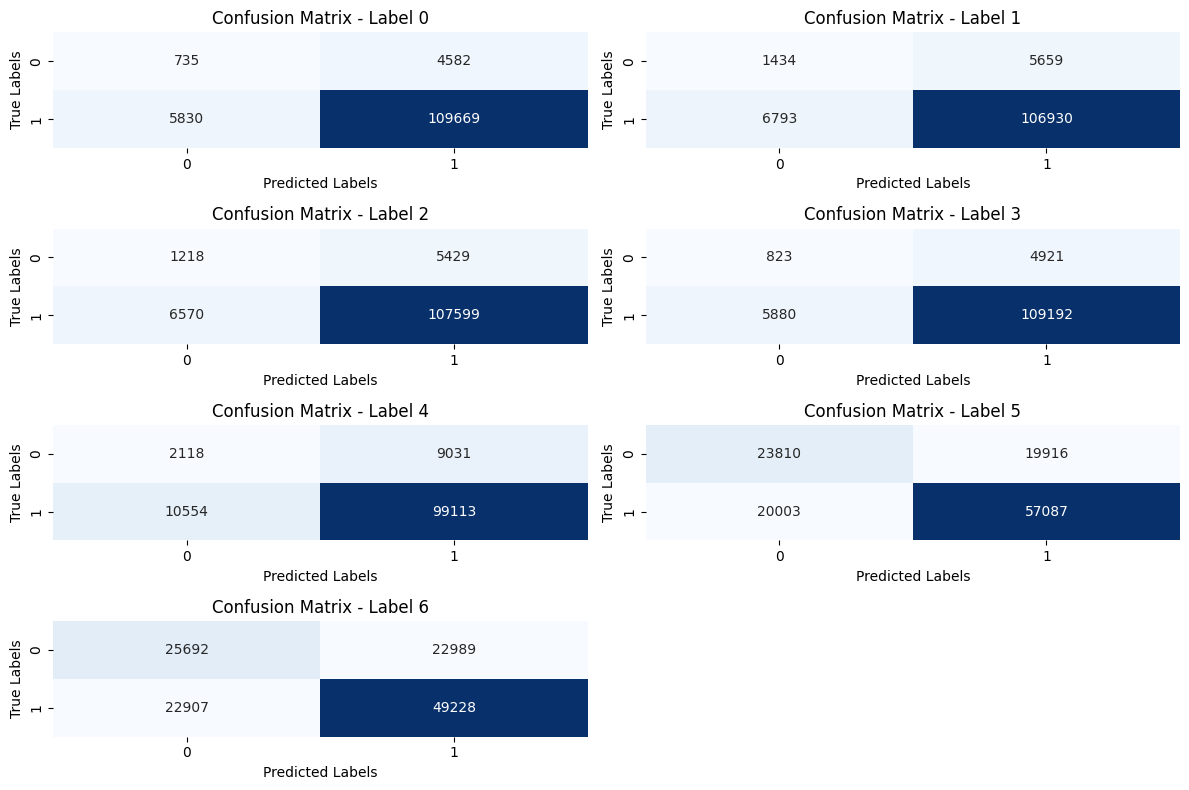

In [23]:
# Multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, predictions_dense)

# Determine the grid dimensions for subplots
num_labels = cm.shape[0]
cols = min(num_labels, 2)
rows = (num_labels + cols - 1) // cols

# Plot confusion matrix
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
for i, (matrix, ax) in enumerate(zip(cm, axes.ravel())):
    sns.heatmap(matrix, annot=True, fmt="d", cbar=False, cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - Label {i}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Remove unused subplots if necessary
if num_labels < rows * cols:
    for j in range(num_labels, rows * cols):
        fig.delaxes(axes.ravel()[j])

plt.tight_layout()
plt.show()

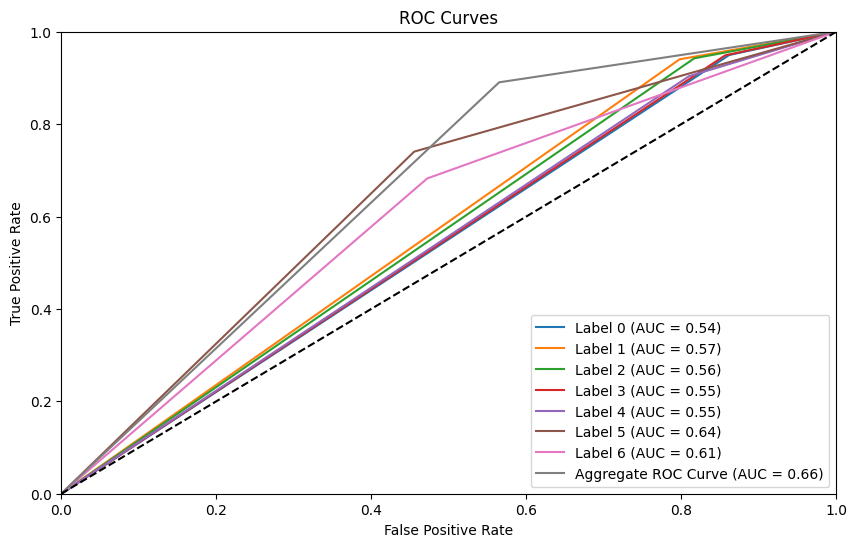

In [27]:
# Initialize the roc_auc_per_label dictionary
roc_auc_per_label = {}

# Plot ROC curve for each label
plt.figure(figsize=(10, 6))
for i in range(y.shape[1]):
    y_test_label = np.squeeze(y_test[:, i].toarray()) if issparse(y_test[:, i]) else np.squeeze(y_test[:, i])
    y_pred_label = np.squeeze(predictions_dense[:, i].toarray()) if issparse(predictions_dense[:, i]) else np.squeeze(predictions_dense[:, i])
    fpr, tpr, _ = roc_curve(y_test_label, y_pred_label)
    roc_auc_per_label[i] = roc_auc_score(y_test_label, y_pred_label)
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' % (i, roc_auc_per_label[i]))

# Plot aggregate AUC ROC
fpr_aggregate, tpr_aggregate, _ = roc_curve(y_test.ravel(), predictions_dense.ravel())
roc_auc_aggregate = roc_auc_score(y_test.ravel(), predictions_dense.ravel())
plt.plot(fpr_aggregate, tpr_aggregate, label='Aggregate ROC Curve (AUC = %0.2f)' % roc_auc_aggregate)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


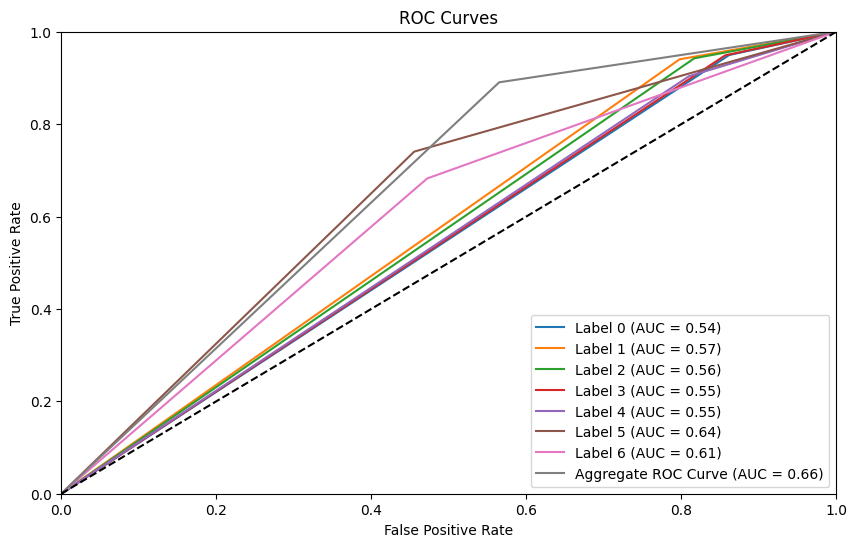

In [28]:
# Initialize the roc_auc_per_label dictionary
roc_auc_per_label = {}

# Plot ROC curve for each label
plt.figure(figsize=(10, 6))
for i in range(y.shape[1]):
    y_test_label = np.array(y_test[:, i].toarray().ravel()) if issparse(y_test[:, i]) else np.array(y_test[:, i])
    y_pred_label = np.array(predictions_dense[:, i].toarray().ravel()) if issparse(predictions_dense[:, i]) else np.array(predictions_dense[:, i])
    fpr, tpr, _ = roc_curve(y_test_label, y_pred_label)
    roc_auc_per_label[i] = roc_auc_score(y_test_label, y_pred_label)
    plt.plot(fpr, tpr, label='Label %d (AUC = %0.2f)' % (i, roc_auc_per_label[i]))

# Plot aggregate AUC ROC
fpr_aggregate, tpr_aggregate, _ = roc_curve(y_test.ravel(), predictions_dense.ravel())
roc_auc_aggregate = roc_auc_score(y_test.ravel(), predictions_dense.ravel())
plt.plot(fpr_aggregate, tpr_aggregate, label='Aggregate ROC Curve (AUC = %0.2f)' % roc_auc_aggregate)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


# 2. Matrix Evaluation Example Based


In [22]:
# Evaluation metrics
accuracy = accuracy_score(y_test, predictions_dense)
precision = precision_score(y_test, predictions_dense, average='micro')
recall = recall_score(y_test, predictions_dense, average='micro')
f1 = f1_score(y_test, predictions_dense, average='micro')
hamming_loss_score = hamming_loss(y_test, predictions_dense)
jaccard = jaccard_score(y_test, predictions_dense, average='micro')
auc_roc = roc_auc_score(y_test, predictions_dense)

In [29]:
# Print results
print('Training Time:', round(training_time, 2), 'seconds')
print('Cross-validated Testing Time:', round(cross_val_time, 2), 'seconds')
print('Testing Time on Specific Test Set:', round(testing_time, 2), 'seconds')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Hamming Loss:', hamming_loss_score)
print('Jaccard Score:', jaccard)
print('AUC-ROC:', auc_roc)

Training Time: 101.23 seconds
Cross-validated Testing Time: 1282.37 seconds
Testing Time on Specific Test Set: 0.33 seconds
Accuracy: 0.2984207389749702
Precision: 0.8980424407284792
Recall: 0.8905186413979131
F1 Score: 0.894264716175544
Hamming Loss: 0.17862345573906957
Jaccard Score: 0.8087511805560831
AUC-ROC: 0.5740760765770225


In [30]:
import sklearn.metrics

print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, predictions_dense, normalize=True, sample_weight=None)))
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_test, predictions_dense))) 
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=predictions_dense, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=predictions_dense, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=predictions_dense, average='samples'))) 

Exact Match Ratio: 0.2984207389749702
Hamming loss: 0.17862345573906957


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.8922602099375044
Precision: 0.8845788519023026
F1 Measure: 0.8775177388221189


In [31]:
#Subet Accuracy atau Exact Match Ratio
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.2984207389749702

In [32]:
# HITUNG HAMMING LOSS
from sklearn.metrics import hamming_loss
hamming_loss(y_test, predictions)

0.17862345573906957

In [33]:
from sklearn.metrics import jaccard_score
print('jaccard_score_Samples: {0}'.format(jaccard_score(y_test, predictions, average='samples')))
print('jaccard_score_Micro: {0}'.format(jaccard_score(y_test, predictions, average="micro")))
print('jaccard_score_Macro: {0}'.format(jaccard_score(y_test, predictions, average="macro")))


jaccard_score_Samples: 0.804063794767013
jaccard_score_Micro: 0.8087511805560831
jaccard_score_Macro: 0.7942359238388806


In [34]:
from sklearn.metrics import zero_one_loss
print('Zero_one_loss: {0}'.format(zero_one_loss(y_test, predictions)))
print('Zero_one_loss_Samples: {0}'.format(zero_one_loss(y_test, predictions, normalize=False)))

Zero_one_loss: 0.7015792610250298
Zero_one_loss_Samples: 84762


In [35]:
from sklearn.metrics import f1_score

print('f1_score_micro: {0}'.format(f1_score(y_test, predictions, average='micro')))
print('f1_score_macro: {0}'.format(f1_score(y_test, predictions, average='macro')))
print('f1_score_weighted: {0}'.format(f1_score(y_test, predictions, average='weighted')))
print('f1_score_none: {0}'.format(f1_score(y_test, predictions, average=None)))


f1_score_micro: 0.894264716175544
f1_score_macro: 0.8761140649810921
f1_score_weighted: 0.8944582400790526
f1_score_none: [0.95468118 0.94497861 0.9471868  0.95287213 0.91008259 0.74094216
 0.68205498]


In [36]:
from sklearn.metrics import fbeta_score

print('fbeta_macro: {0}'.format(fbeta_score(y_test, predictions, average='macro', beta=0.5)))
print('fbeta_micro: {0}'.format(fbeta_score(y_test, predictions, average='micro', beta=0.5)))
print('fbeta_weighted: {0}'.format(fbeta_score(y_test, predictions, average='weighted', beta=0.5)))
print('fbeta_none: {0}'.format(fbeta_score(y_test, predictions, average=None, beta=0.5)))

fbeta_macro: 0.8782691041137499
fbeta_micro: 0.8965275273069707
fbeta_weighted: 0.8968427132881472
fbeta_none: [0.95780284 0.94782823 0.95004953 0.95527047 0.91391682 0.74119324
 0.68182259]


In [37]:
from sklearn.metrics import precision_recall_fscore_support

print('recision_recall_fscore_support_macro: {0}'.format(precision_recall_fscore_support(y_test, predictions, average='macro')))
print('recision_recall_fscore_support_micro: {0}'.format(precision_recall_fscore_support(y_test, predictions, average='micro')))
print('recision_recall_fscore_support_weighted: {0}'.format(precision_recall_fscore_support(y_test, predictions, average='weighted')))
print('recision_recall_fscore_support_none: {0}'.format(precision_recall_fscore_support(y_test, predictions, average=None)))

recision_recall_fscore_support_macro: (0.8797137206771044, 0.8725536737836238, 0.8761140649810921, None)
recision_recall_fscore_support_micro: (0.8980424407284792, 0.8905186413979131, 0.894264716175544, None)
recision_recall_fscore_support_weighted: (0.8984410903444595, 0.8905186413979131, 0.8944582400790526, None)
recision_recall_fscore_support_none: (array([0.95989532, 0.94973754, 0.95196765, 0.95687608, 0.91649097,
       0.74136073, 0.68166775]), array([0.94952337, 0.94026714, 0.94245373, 0.94890156, 0.90376321,
       0.74052406, 0.68244264]), array([0.95468118, 0.94497861, 0.9471868 , 0.95287213, 0.91008259,
       0.74094216, 0.68205498]), array([115499, 113723, 114169, 115072, 109667,  77090,  72135]))


In [38]:
from sklearn.metrics import precision_score
print('precision_score_macro: {0}'.format(precision_score(y_test, predictions, average='macro')))
print('precision_score_micro: {0}'.format(precision_score(y_test, predictions, average='micro')))
print('precision_score_weighted: {0}'.format(precision_score(y_test, predictions, average='weighted')))
print('precision_score_none: {0}'.format(precision_score(y_test, predictions, average=None)))
print('precision_score_zero_divisio: {0}'.format(precision_score(y_test, predictions, average=None, zero_division=1)))


precision_score_macro: 0.8797137206771044
precision_score_micro: 0.8980424407284792
precision_score_weighted: 0.8984410903444595
precision_score_none: [0.95989532 0.94973754 0.95196765 0.95687608 0.91649097 0.74136073
 0.68166775]
precision_score_zero_divisio: [0.95989532 0.94973754 0.95196765 0.95687608 0.91649097 0.74136073
 0.68166775]


In [39]:
from sklearn.metrics import recall_score
print('recall_score_macro: {0}'.format(recall_score(y_test, predictions, average='macro')))
print('recall_score_micro: {0}'.format(recall_score(y_test, predictions, average='micro')))
print('recall_score_weighted: {0}'.format(recall_score(y_test, predictions, average='weighted')))
print('recall_score_none: {0}'.format(recall_score(y_test, predictions, average=None)))
print('recall_score_zero_divisio: {0}'.format(recall_score(y_test, predictions, average=None, zero_division=1)))


recall_score_macro: 0.8725536737836238
recall_score_micro: 0.8905186413979131
recall_score_weighted: 0.8905186413979131
recall_score_none: [0.94952337 0.94026714 0.94245373 0.94890156 0.90376321 0.74052406
 0.68244264]
recall_score_zero_divisio: [0.94952337 0.94026714 0.94245373 0.94890156 0.90376321 0.74052406
 0.68244264]


In [40]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, predictions)

array([[[   735,   4582],
        [  5830, 109669]],

       [[  1434,   5659],
        [  6793, 106930]],

       [[  1218,   5429],
        [  6570, 107599]],

       [[   823,   4921],
        [  5880, 109192]],

       [[  2118,   9031],
        [ 10554,  99113]],

       [[ 23810,  19916],
        [ 20003,  57087]],

       [[ 25692,  22989],
        [ 22907,  49228]]])

In [41]:
# CLASSIFICATION REPORT : precision, recacll f1-score support every label
from sklearn.metrics import classification_report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    115499
           1       0.95      0.94      0.94    113723
           2       0.95      0.94      0.95    114169
           3       0.96      0.95      0.95    115072
           4       0.92      0.90      0.91    109667
           5       0.74      0.74      0.74     77090
           6       0.68      0.68      0.68     72135

   micro avg       0.90      0.89      0.89    717355
   macro avg       0.88      0.87      0.88    717355
weighted avg       0.90      0.89      0.89    717355
 samples avg       0.89      0.88      0.88    717355



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print("Actual \n", y_test)
print("\nPredicted \n", predictions)

Actual 
 [[1 1 1 ... 1 0 0]
 [0 1 1 ... 1 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]]

Predicted 
   (0, 0)	1
  (1, 0)	1
  (2, 0)	1
  (3, 0)	1
  (4, 0)	1
  (5, 0)	1
  (6, 0)	1
  (7, 0)	1
  (8, 0)	1
  (9, 0)	1
  (10, 0)	1
  (11, 0)	1
  (12, 0)	1
  (13, 0)	1
  (14, 0)	1
  (15, 0)	1
  (16, 0)	1
  (17, 0)	1
  (18, 0)	1
  (19, 0)	1
  (20, 0)	1
  (21, 0)	1
  (22, 0)	1
  (23, 0)	1
  (24, 0)	1
  :	:
  (120777, 6)	1
  (120778, 6)	1
  (120780, 6)	1
  (120785, 6)	1
  (120786, 6)	1
  (120787, 6)	1
  (120788, 6)	1
  (120791, 6)	1
  (120792, 6)	1
  (120793, 6)	1
  (120794, 6)	1
  (120795, 6)	1
  (120797, 6)	1
  (120800, 6)	1
  (120801, 6)	1
  (120802, 6)	1
  (120805, 6)	1
  (120806, 6)	1
  (120808, 6)	1
  (120809, 6)	1
  (120810, 6)	1
  (120811, 6)	1
  (120812, 6)	1
  (120814, 6)	1
  (120815, 6)	1
